In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if ".." not in sys.path:
    sys.path.append('..')

gen_dir = '../generations/memo/fifty_fifty/split0'

In [ ]:
from html import escape
from IPython.display import HTML

def _is_leaf(obj):
    """True if `obj` is not a list / tuple / set / dict."""
    return not isinstance(obj, (list, tuple, set, dict))
17
def _to_details(obj, title="Item", depth=0, auto_preleaf=False):
    """Recursively wrap `obj` in <details>/<summary>."""
    indent = " " * 4 * depth
    inner_html = ""

    # Decide how to render the current object's children
    if isinstance(obj, dict):
        # Dict → each key becomes a nested collapsible
        inner_html = "\n".join(
            _to_details(v, title=k, depth=depth + 1, auto_preleaf=auto_preleaf) for k, v in obj.items()
        )
        is_preleaf = all(_is_leaf(v) for v in obj.values())
    elif isinstance(obj, (list, tuple, set)):
        # Iterable → each element gets its own collapsible
        inner_html = "\n".join(
            _to_details(item, title=f"{title}-{i}", depth=depth + 1, auto_preleaf=auto_preleaf)
            for i, item in enumerate(obj, 1)
        )
        is_preleaf = all(_is_leaf(el) for el in obj)
    else:
        # show the title inline, then the value
        return (
            f"{indent}<div>"
            f"<strong>{escape(str(title))}</strong>: "
            f"{escape(str(obj))}"
            f"</div>"
        )

    # Wrap the generated inner HTML in a details block
    open_attr = " open" if (auto_preleaf and is_preleaf) else ""
    return (
        f"{indent}<details{open_attr}>\n"
        f"{indent}    <summary><strong>{escape(str(title))}</strong></summary>\n"
        f"{inner_html}\n"
        f"{indent}</details>"
    )

def show_collapsible(data, root_title="Root"):
    """Display a nested collapsible representation of `data`."""
    html = _to_details(data, title=root_title)
    return html


In [4]:
from dataclasses import asdict
import math
from datasets import load_dataset
from memorization import score_at_k, extract_answer, default_scoring_fn
import json
from tqdm.notebook import tqdm

datapoints = []
overall = {}
for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
    overall[freq] = []
    qa = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
    qa_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.aug.parquet')['train']
    qa_ref_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_aug.parquet')['train']
    qa_ref_doc = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.ref_doc.parquet')['train']
    print(qa_ref_aug)
    for i in tqdm(range(len(qa))):
        overall[freq].append([])
        datapoint = {}
        question = qa[i]['question']
        label = json.loads(qa[i]['possible_answers'])

        # qa
        answers = json.loads(qa[i]['model_predictions'])    
        # qa_aug/max/avg_over...    
        aug_answers = json.loads(qa_aug[i]['model_self_augmented_predictions'])
        aug_completions = json.loads(qa_aug[i]['model_completions'])

        # qa_ref_aug/max_avg_over...
        ref_aug_answers = json.loads(qa_ref_aug[i]['model_self_augmented_predictions'])
        ref_aug_completions = json.loads(qa_ref_aug[i]['model_completions'])
 
        # qa straight
        ext_answers = list(map(extract_answer, answers))
        datapoint['question'] = question
        datapoint['label'] = label
        datapoint['s_pop'] = qa[i]['s_pop']
        datapoint['qa/score@1'] = asdict(score_at_k(label, ext_answers, default_scoring_fn))


        # get a point for ref aug
        if qa_aug[i]['prefix_before_answer_extraction_success']:
            max_doc_ref_pass_at_1 = -math.inf            
            for l, ref_answers in enumerate(json.loads(qa_aug[i]['model_ref_augmented_predictions'])):
                ext_ref_answers = list(map(extract_answer, ref_answers))
                score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
                if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                    max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                    datapoint['qa_ref/prefix/score@1'] = asdict(score_at_1_ref_of_doc)
                    datapoint['qa_ref/prefix/doc_index'] = l
                    datapoint['qa_ref/prefix/doc'] = qa_aug[i]['s_docs'][l]
                    datapoint['qa_ref/prefix/ref'] = qa_aug[i]['prefix_before_answer']
        else:
            datapoint['qa_ref/prefix/score@1'] = None
        
        # get a point for ref doc
        max_doc_ref_pass_at_1 = -math.inf

        for l, ref_answers in enumerate(json.loads(qa_ref_doc[i]['model_ref_doc_augmented_predictions'])):
            ext_ref_answers = list(map(extract_answer, ref_answers))
            score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
            if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
                max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
                datapoint['qa_ref/doc/score@1'] = asdict(score_at_1_ref_of_doc)
                datapoint['qa_ref/doc/doc_index'] = l
                datapoint['qa_ref/doc/doc'] = qa_ref_doc[i]['s_docs'][l]['text'][:2048*4]

        # get points for self-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(aug_answers, aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/self/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/self/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/self/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/self/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/self/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/self/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/self/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/self/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        
        # get points for prefix-completion
        max_doc_max_comp_pass_at_1 = -math.inf
        max_doc_avg_comp_pass_at_1 = -math.inf
        for j, (aug_group, completion_group) in enumerate(zip(ref_aug_answers, ref_aug_completions)):
            overall[freq][-1].append([])
            all_ext_aug_answers = []
            for k, (aug_subgroup, completion) in enumerate(zip(aug_group, completion_group)):
                ext_aug_answers =list(map(extract_answer, aug_subgroup))
                overall[freq][-1][-1].append({})
                overall[freq][-1][-1][-1]['question'] = question
                overall[freq][-1][-1][-1]['label'] = label
                overall[freq][-1][-1][-1]['completion'] = completion
                overall[freq][-1][-1][-1]['answers'] = answers
                overall[freq][-1][-1][-1]['ext_answers'] = ext_answers
                overall[freq][-1][-1][-1]['augmented_answers'] = aug_subgroup
                overall[freq][-1][-1][-1]['ext_aug_answers'] = ext_aug_answers
                all_ext_aug_answers.extend(ext_aug_answers)
                score_at_1_given_completion = score_at_k(label, ext_aug_answers, default_scoring_fn)
                if score_at_1_given_completion.mean >= max_doc_max_comp_pass_at_1:
                    max_doc_max_comp_pass_at_1 = score_at_1_given_completion.mean
                    datapoint['qa_aug/ref/max_over_completion/score@1'] = asdict(score_at_1_given_completion)
                    datapoint['qa_aug/ref/max_over_completion/doc_index'] = j 
                    datapoint['qa_aug/ref/max_over_completion/doc'] = qa[i]['s_docs'][j]['text']
                    datapoint['qa_aug/ref/max_over_completion/completion_index'] = k
                    datapoint['qa_aug/ref/max_over_completion/completion'] = completion
            score_at_1_marginalized_over_completions = score_at_k(label, all_ext_aug_answers, default_scoring_fn)
            if score_at_1_marginalized_over_completions.mean >= max_doc_avg_comp_pass_at_1:
                max_doc_avg_comp_pass_at_1 = score_at_1_marginalized_over_completions.mean
                datapoint['qa_aug/ref/avg_over_completion/score@1'] = asdict(score_at_1_marginalized_over_completions)            
                datapoint['qa_aug/ref/avg_over_completion/doc_index'] = j 
                datapoint['qa_aug/ref/avg_over_completion/doc'] = qa[i]['s_docs'][j]['text']
        datapoints.append(datapoint)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 97
})


  0%|          | 0/97 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 90
})


  0%|          | 0/90 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 91
})


  0%|          | 0/91 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['id', 'subj', 'prop', 'obj', 'subj_id', 'prop_id', 'obj_id', 's_aliases', 'o_aliases', 's_uri', 'o_uri', 's_wiki_title', 'o_wiki_title', 's_pop', 'o_pop', 'question', 'possible_answers', 's_docs', 'o_docs', 'prefix_before_subject', 'prefix_before_answer', 'model_completions', 'prefix_before_answer_extraction_success', 'model_self_augmented_predictions', 'model_ref_augmented_predictions'],
    num_rows: 81
})


  0%|          | 0/81 [00:00<?, ?it/s]

In [5]:
# cnt = 0
# for freq in ['0_to_1000', '1000_to_10000', '10000_to_100000', '100000_to_inf']:
#     qa = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.wikilinked.qa.parquet')['train']
#     qa_aug = load_dataset('parquet', data_files=f'{gen_dir}/{freq}/dev.decon.wikilinked.qa.aug.parquet')['train']
#     for i in tqdm(range(len(qa))):
#         answers = json.loads(qa[i]['model_predictions'])
#         aug_answers = json.loads(qa_aug[i]['model_self_augmented_predictions'])
#         aug_completions = json.loads(qa_aug[i]['model_completions'])
#         question = qa[i]['question']
#         label = json.loads(qa[i]['possible_answers'])
#         if qa_aug[i]['prefix_before_answer_extraction_success']:
#             max_doc_ref_pass_at_1 = -math.inf
#             for l, ref_answers in enumerate(json.loads(qa_aug[i]['model_ref_augmented_predictions'])):
#                 ext_ref_answers = list(map(extract_answer, ref_answers))
#                 score_at_1_ref_of_doc = score_at_k(label, ext_ref_answers, default_scoring_fn)
#                 if score_at_1_ref_of_doc.mean >= max_doc_ref_pass_at_1:
#                     max_doc_ref_pass_at_1 = score_at_1_ref_of_doc.mean
#                     datapoints[cnt]['qa_aug/ref/pass@1'] = asdict(score_at_1_ref_of_doc)
#                     datapoints[cnt]['qa_aug/ref/doc_index'] = l
#                     datapoints[cnt]['qa_aug/ref/doc'] = qa[i]['s_docs'][l]
#                     datapoints[cnt]['qa_aug/ref/ref'] = qa_aug[i]['prefix_before_answer']
#         else:
#             datapoint[i]['qa_aug/ref/pass@1'] = None
#         cnt += 1

In [6]:
len(overall['100000_to_inf'])

81

In [7]:
with open('data/0611_memo/memo_results.html', 'wt') as f:
    print(show_collapsible(overall), file=f)

with open('data/0611_memo/pass_at_1.json', 'wt') as f:
    print(json.dumps(datapoints, indent=4), file=f)

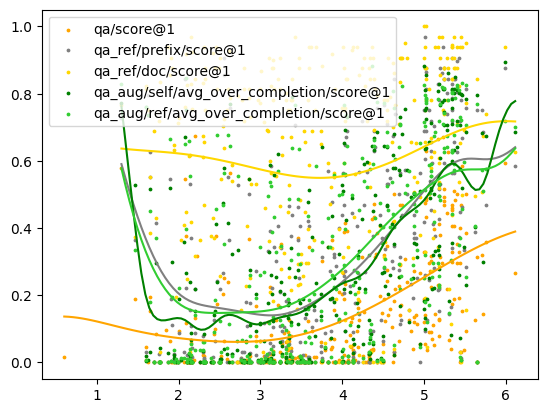

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.nonparametric.kernel_regression import KernelReg 
config = {
    'qa/score@1': {
        'plot' : {
            'color': 'orange'
        },
    },
    'qa_ref/prefix/score@1': {
        'plot' : {
            'color': 'grey'
        },
    }, 
    'qa_ref/doc/score@1': {
        'plot' : {
            'color': 'gold'
        },
    }, 
    'qa_aug/self/avg_over_completion/score@1': {
        'plot' : {
            'color': 'green'
        },
    }, 
    # 'qa_aug/self/max_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'blue'
    #     },
    # },
    'qa_aug/ref/avg_over_completion/score@1': {
        'plot' : {
            'color': 'limegreen'
        },
    }, 
    # 'qa_aug/ref/max_over_completion/score@1': {
    #     'plot' : {
    #         'color': 'cyan'
    #     },
    # },

}

for key in config:
    xs = []
    ys = []
    for point in datapoints:
        if key in point and point[key] is not None:
            xs.append(point['s_pop'])
            ys.append(point[key]['mean'])
    xs = np.log10(xs)
    plt.scatter(xs, ys, label=key, s=3, **config[key]['plot'])
    reg = KernelReg(ys, xs, 'c')
    grid = np.linspace(min(xs), max(xs), 100)
    reg_y_mean, _ = reg.fit(grid)
    plt.plot(grid, reg_y_mean, **config[key]['plot'])
plt.legend()
plt.show()

In [9]:
qa_aug[0]['model_ref_augmented_predictions']
qa_aug[0]['model_ref_augmented_predictions']

'[["Sucre <thought>La Paz is the political and administrative capital</thought> but Sucre is the constitutional capital of Bolivia <answer>Sucre</answer>.", "<thought> The constitutional capital of Bolivia is Sucre. </thought> <answer> Sucre </answer>", "<thought> The constitutional capital of Bolivia is Sucre. </thought> <answer> Sucre</answer>", "<thought> The constitutional capital of Bolivia is Sucre. However, I\'m not sure whether this detail was among the information previously stored. </thought> \\n<answer> Sucre", "<thought>That information about Bolivia seems relevant but doesn\'t directly answer the question about its capital. Since the question asks for the capital and not the seat of government or constitutional capital, focusing on the primary administrative center would give a straight answer.</thought> The capital of Bolivia is <answer>Sucre</answer>.", "<thought> Bolivia\'s constitutional capital is Sucre </thought> <answer> Sucre </answer>", "<thought>Based on the info

In [43]:
dat_file = load_dataset('parquet', data_files=f'{gen_dir}/0_to_1000/dev.decon.wikilinked.qa.ref_doc.parquet')['train']
print(dat_file[-1]['question'])
print(dat_file[-1]['possible_answers'])
json.loads(dat_file[-1]['model_ref_doc_augmented_predictions'])

Who was the producer of Pizza?
["Alain Bashung", "Alain Claude Baschung"]


[['<thought>Upon recalling that "Pizza" is the third album by French rocker Alain Bashung and given the mention of Philips Records in the provided information, the producer of "Pizza" would likely be associated with this record production through the label. <thought> Given there is no explicit mention of a producer by name in the provided information, and focusing on the context which names Alain Bashung as the primary artist and Philips Records as the label, a reasonable conclusion without additional specific data might be that the producer was someone who worked under the aegis of Philips Records during the time of "Pizza"s release. <thought> However, to provide a definitive answer, more specific information about the production team associated with "Pizza" would be needed. <answer> Philips Records Producer',
  '<thought>Given the detailed information about Alain Bashung and his album "Pizza"...</thought> <answer>Alain Bashung</answer>',
  '<thought>Alain Bashung</thought> was the pr

In [29]:
HTML(show_collapsible(datapoints[-1]))

In [ ]:
ns']